In [2]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
sns.set_style("whitegrid")
from pprint import pprint
import sqlite3
import yaml
import re
from datetime import datetime
import maya
from collections import Counter
from glob import glob
import ast
import json
from sklearn.preprocessing import StandardScaler

try: # for pip >= 10
    from pip._internal.req import parse_requirements
except ImportError: # for pip <= 9.0.3
    from pip.req import parse_requirements

from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

import networkx as nx
import networkx.algorithms.community as nxcom

import bokeh.io
from bokeh.io import output_file, show
from bokeh.resources import INLINE
from bokeh.models import (BoxSelectTool, Circle, EdgesAndLinkedNodes, HoverTool,
                          MultiLine, NodesAndLinkedEdges, Plot, Range1d, TapTool,
                         BoxZoomTool, ResetTool, OpenURL, CustomJS, Column, SaveTool)
from bokeh.palettes import Spectral4
from bokeh.plotting import figure, output_notebook
from bokeh.models.graphs import from_networkx
from bokeh.models import TextInput, Button

%matplotlib inline

# Code for hiding seaborn warnings
import warnings
warnings.filterwarnings("ignore")

## Easier navigation:

------------------------------------

### 1. <a href='#setup1'>Setup timing csv</a>
### 2. <a href='#setup2'>Setup dependency/size csv</a>
### 3. <a href='#setup3'>Setup scrape csv</a>
------------------------------------
### 4. <a href='#e1'>Timing csv EDA</a>
### 5. <a href='#e2'>Dependency/size csv EDA</a>
### 6. <a href='#e3'>Scrape csv EDA</a>
------------------------------------
### 7. <a href='#merge'>Merge CSVs</a>
------------------------------------
### 8. <a href='#c1'>Correlational plots for time vs size</a>

In [3]:
with open('q_df.txt') as f:
    reloaded_example = json.load(f)

In [4]:
df = pd.read_json(reloaded_example)
df

,index,library,dependencies,total size,size_full,Contributors,Dependencies,Dependent packages,Dependent repositories,First release,...,Incoming Dep,Outgoing Dep,Degree,Closeness,Katz,Hub,Authority,dependencies_temp,size,timetaken
0,0,matplotlib,"[cycler, kiwisolver]",60.000,35M /home/ubuntu/ve/randomenv/lib/python3.6/si...,763.0,0.0,10100.0,39600.0,"Jan 9, 2006",...,75,7,0.073345,0.067084,0.048731,0.000709,0.003557,"[cycler, kiwisolver]",19.496,-0.31275
1,1,numpy,[],25.000,25M /home/ubuntu/ve/randomenv/lib/python3.6/si...,736.0,0.0,25500.0,84900.0,"Dec 2, 2006",...,271,0,0.242397,0.242397,0.193062,0.000000,0.009493,[],25.000,0.31375
2,2,pandas,[],74.800,47M /home/ubuntu/ve/randomenv/lib/python3.6/si...,970.0,0.0,14500.0,38400.0,"Dec 25, 2009",...,105,4,0.097496,0.093918,0.067608,0.000519,0.005825,[],31.776,-0.12125
3,3,scipy,[],87.000,62M /home/ubuntu/ve/randomenv/lib/python3.6/si...,680.0,1.0,10400.0,43400.0,"Jul 27, 2010",...,114,1,0.102862,0.101968,0.074220,0.000089,0.003385,[],61.876,0.24475
4,4,ipywidgets,"[nbclient, terminado, testpath, jedi, argon2-c...",78.292,39M /home/ubuntu/ve/randomenv/lib/python3.6/si...,NaN,8.0,734.0,7470.0,"Aug 3, 2015",...,44,53,0.086762,0.039356,0.031343,0.006734,0.006981,"[nbclient, terminado, testpath, jedi, argon2-c...",-17.704,-0.38325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
944,944,imgkit,[],0.060,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,7.0,1.0,11.0,31.0,"Jan 30, 2017",...,0,1,0.000894,0.000000,0.005575,0.000187,0.000000,[],0.000,0.00000
945,945,sphinx_tabs,"[sphinx, sphinxcontrib-qthelp, imagesize, sphi...",65.700,30M /home/ubuntu/ve/randomenv/lib/python3.6/si...,14.0,11.0,41.0,178.0,"Jan 22, 2017",...,0,24,0.021467,0.000000,0.005575,0.001573,0.000000,"[sphinx, sphinxcontrib-qthelp, imagesize, sphi...",-23.712,-0.76850
946,946,lea,[],0.716,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,0.0,0.0,0.0,21.0,"Jul 27, 2013",...,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,[],0.716,0.18450
947,947,requests-html,"[pyppeteer, fake-useragent, pyquery, parse, bs...",22.080,15M /home/ubuntu/ve/randomenv/lib/python3.6/si...,41.0,7.0,135.0,182.0,"Feb 24, 2018",...,0,13,0.011628,0.000000,0.005575,0.000395,0.000000,"[pyppeteer, fake-useragent, pyquery, parse, bs...",17.980,0.25475


<a name='e1'></a>
## 5. Timing csv EDA


<br>

Let's say for now, we take the real time.

<AxesSubplot:xlabel='real avg', ylabel='Density'>

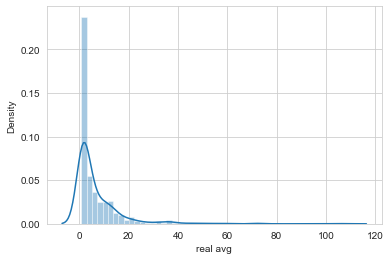

In [450]:
sns.distplot(df["real avg"])

Difference between max and avg for count > 1

In [451]:
bigcount = df[df["count"].apply(lambda x: float(x)) > 1]

<AxesSubplot:>

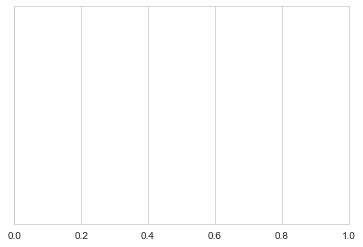

In [452]:
sns.boxplot(bigcount["real max"].astype(float) - bigcount["real avg"].astype(float))

<a name='e2'></a>
## 6. Dependency/size csv EDA

 - Package size
 - Package dependencies
 
 Columns: ['library', 'dependencies', 'size', 'size_full']
<br>

Why is package name not in install?

In [453]:
df["size_full"]

0      35M /home/ubuntu/ve/randomenv/lib/python3.6/si...
1      25M /home/ubuntu/ve/randomenv/lib/python3.6/si...
2      47M /home/ubuntu/ve/randomenv/lib/python3.6/si...
3      62M /home/ubuntu/ve/randomenv/lib/python3.6/si...
4      39M /home/ubuntu/ve/randomenv/lib/python3.6/si...
                             ...                        
995    11M /home/ubuntu/ve/randomenv/lib/python3.6/si...
996    30M /home/ubuntu/ve/randomenv/lib/python3.6/si...
997    11M /home/ubuntu/ve/randomenv/lib/python3.6/si...
998    15M /home/ubuntu/ve/randomenv/lib/python3.6/si...
999    11M /home/ubuntu/ve/randomenv/lib/python3.6/si...
Name: size_full, Length: 949, dtype: object

In [454]:
counter = 0
for index, row in df.iterrows():
    counter += row["library"] in (row["size_full"]) 
counter / len(df)

0.6080084299262382

Standard stuff:

<AxesSubplot:xlabel='size', ylabel='Count'>

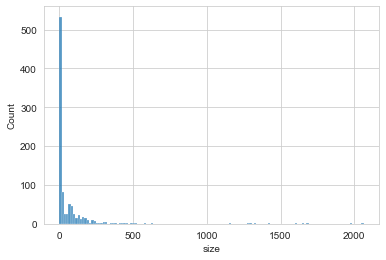

In [462]:
sns.histplot(df["size"])

(0.0, 200.0)

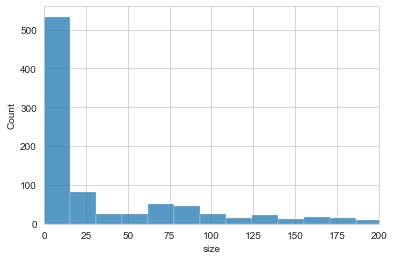

In [472]:
fig, ax = plt.subplots()
sns.histplot(df["size"], ax=ax)
ax.set_xlim(0,200)

dep_len

<AxesSubplot:xlabel='dep_len', ylabel='Count'>

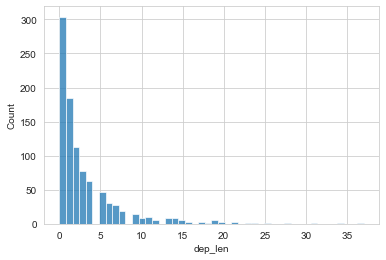

In [573]:
sns.histplot(df["dep_len"])

In [583]:
df.sort_values('dep_len', ascending=False)

,library,dependencies,size,size_full,Contributors,Dependencies,Dependent packages,Dependent repositories,First release,Forks,...,real std,real max,count,sys avg,sys std,sys max,user avg,user std,user max,dep_len
769,spyder,"[qtawesome, keyring, rtree, pygments, numpydoc...",173.480,45M /home/ubuntu/ve/randomenv/lib/python3.6/si...,156.0,56.0,29.0,898.0,"Sep 18, 2014",1270.0,...,NaN,32.246,1.0,2.555,NaN,2.555,27.615,NaN,27.615,37
564,datapane,"[nbconvert, requests-toolbelt, packaging, json...",421.956,128M /home/ubuntu/ve/randomenv/lib/python3.6/s...,NaN,33.0,0.0,0.0,"Nov 12, 2019",NaN,...,NaN,36.001,1.0,3.263,NaN,3.263,30.019,NaN,30.019,34
595,msticpy,"[pandas, KqlmagicCustom, networkx, azure-mgmt-...",307.520,59M /home/ubuntu/ve/randomenv/lib/python3.6/si...,12.0,80.0,1.0,2.0,"Mar 7, 2019",97.0,...,NaN,36.822,1.0,2.954,NaN,2.954,32.184,NaN,32.184,31
507,tfx,"[apache-beam, attrs, packaging, pyyaml, tensor...",1295.408,927M /home/ubuntu/ve/randomenv/lib/python3.6/s...,NaN,48.0,1.0,2.0,"Mar 2, 2019",459.0,...,NaN,103.522,1.0,6.967,NaN,6.967,67.545,NaN,67.545,28
737,geemap,"[sankee, geocoder, pandas, ipynb-py-convert, i...",353.540,133M /home/ubuntu/ve/randomenv/lib/python3.6/s...,1.0,25.0,2.0,0.0,"Mar 8, 2020",522.0,...,NaN,41.144,1.0,3.607,NaN,3.607,35.108,NaN,35.108,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,pamela,[],0.000,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,6.0,0.0,6.0,117.0,"Sep 8, 2015",9.0,...,NaN,0.939,1.0,0.082,NaN,0.082,0.760,NaN,0.760,0
459,coverage,[],1.300,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,105.0,1.0,3790.0,50200.0,"May 16, 2009",219.0,...,NaN,1.480,1.0,0.111,NaN,0.111,1.329,NaN,1.329,0
457,ipython_genutils,[],0.000,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,NaN,0.0,117.0,3280.0,"Apr 9, 2015",NaN,...,NaN,0.888,1.0,0.088,NaN,0.088,0.772,NaN,0.772,0
452,unidecode,[],2.100,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,NaN,0.0,545.0,7350.0,"Jun 17, 2009",NaN,...,NaN,1.132,1.0,0.117,NaN,0.117,0.981,NaN,0.981,0


<a name='e3'></a>
## 7. Scrape csv EDA

 - Package stats
 - Package versions
 
 Columns: ['library', 'Contributors', 'Dependencies', 'Dependent packages', 'Dependent repositories', 'First release', 'Forks', 'Latest release', 'Open Issues/PRs', 'Repository size', 'SourceRank', 'Stars', 'Total releases', 'Version Number', 'Version Time', 'Watchers']
<br>

Version related stuff:

<a name='c1'></a>
## 8. Scatterplots

<br>

<AxesSubplot:xlabel='size', ylabel='real avg'>

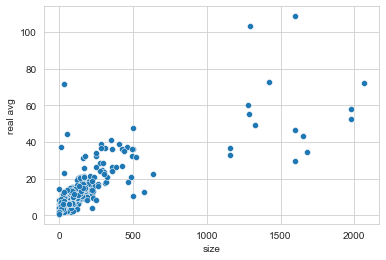

In [495]:
sns.scatterplot(x="size", y="real avg", data=df)

<AxesSubplot:xlabel='dep_len', ylabel='real avg'>

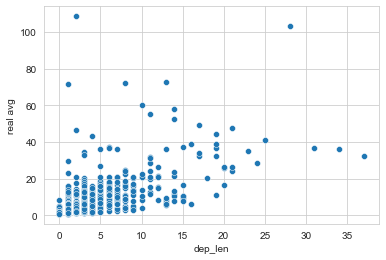

In [493]:
sns.scatterplot(x="dep_len", y="real avg", data=df)

<AxesSubplot:xlabel='size', ylabel='Repository size'>

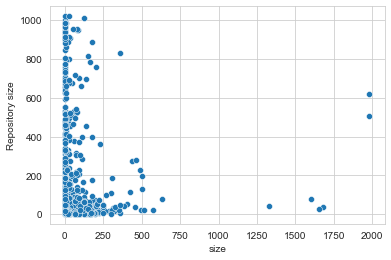

In [494]:
sns.scatterplot(x="size", y="Repository size", data=df)

<AxesSubplot:xlabel='Stars', ylabel='Forks'>

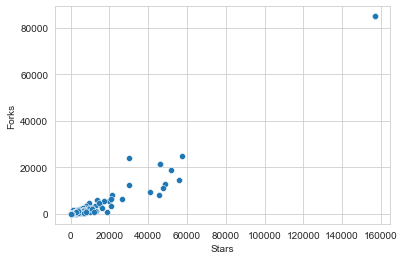

In [527]:
sns.scatterplot(x="Stars", y="Forks", data=df)